# Probabilistic Trajectories

Instead of using raw mobility traces, we instead want to generate simulated mobility traces (why? to get more flexibility in number of mobile sensors/mules). To do this, we first generate a heatmap of places that people go, then write the code to move through that space. 

## Generating Heatmap

We read in a toy dataset to generate a heatmap.

In [188]:
# Import our libraries.
import math
import pickle
import numpy as np
from matplotlib import pyplot as plt
from scipy.ndimage import gaussian_filter1d
from scipy.interpolate import interp1d

In [4]:
file_path = "../galaxy/simulation/smol_attacks/smol_truth/smol_dict.pkl"
with open(file_path, 'rb') as f:
    smol_dict = pickle.load(f)

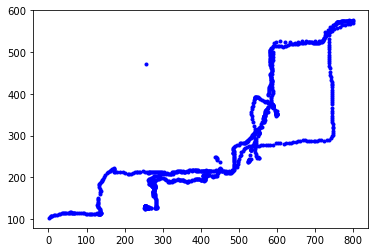

In [8]:
index = '167'

plt.figure()
plt.plot(smol_dict[index]['x'], smol_dict[index]['y'], 'b.')
plt.show()

In [43]:
index = '167'
grain = 5.0
full_size = [800, 600]
heat_size = [math.ceil(size/grain) for size in full_size]

In [32]:
heat_map = np.zeros(heat_size)

for i in range(heat_size[0]):
    for j in range(heat_size[1]):
        heat_map[i, j] = len(smol_dict[index].loc[(smol_dict[index]['x'] > grain*i) &
                                                  (smol_dict[index]['x'] < grain*(i+1)) &
                                                  (smol_dict[index]['y'] > grain*j) &
                                                  (smol_dict[index]['y'] < grain*(j+1))])

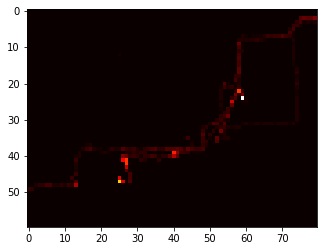

In [33]:
plt.imshow(np.flip(heat_map.T, axis=0), cmap='hot', interpolation='nearest')
plt.show()

In [44]:
x_edges = [i*grain for i in range(heat_size[0] + 1)]
y_edges = [j*grain for j in range(heat_size[1] + 1)]

H, x_edges, y_edges = np.histogram2d(smol_dict[index]['x'], smol_dict[index]['y'], bins=(x_edges, y_edges))

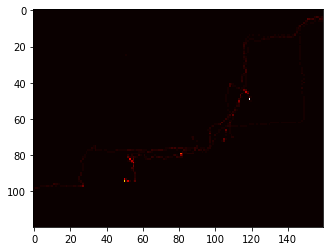

In [47]:
plt.imshow(np.flip(H.T, axis=0), cmap='hot', interpolation='nearest')
plt.show()

In [39]:
H.shape

(80, 60)

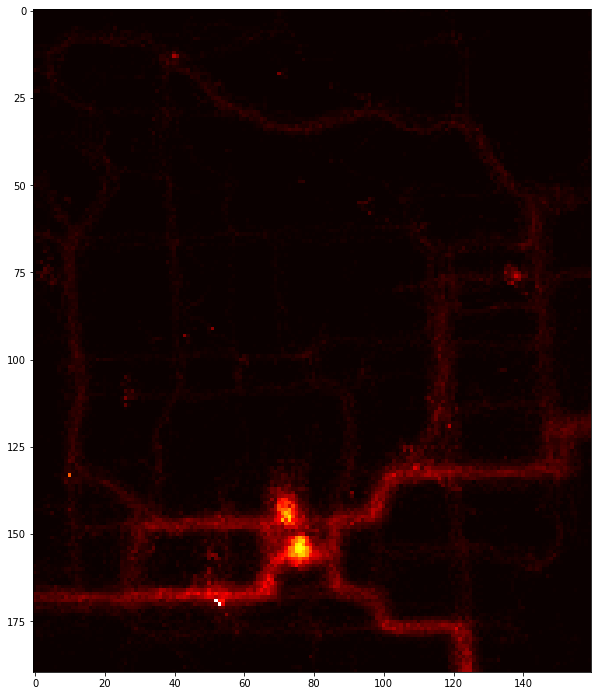

In [59]:
# For all traces.
grain = 5.0
full_size = [800, 950]
heat_size = [math.ceil(size/grain) for size in full_size]

x_edges = [i*grain for i in range(heat_size[0] + 1)]
y_edges = [j*grain for j in range(heat_size[1] + 1)]
heat_map = np.zeros(heat_size)

for index in smol_dict:
    H, x_edges, y_edges = np.histogram2d(smol_dict[index]['x'], smol_dict[index]['y'], bins=(x_edges, y_edges))
    heat_map += H

plt.figure(figsize=(10, 15))
plt.imshow(np.flip(heat_map.T, axis=0), cmap='hot', interpolation='nearest')
plt.show()

## Moving Around

Now, we use this heatmap to generate the general trajectory of some random person walking around.

In [92]:
# Pad the outside of the map with 0s so we don't run off the edge.
pad_size = 1
padded_map = np.pad(heat_map, pad_size)

In [97]:
seed = 1337
np.random.seed(seed)

start_pos = [100, 175] # position in meters
start_ind = [math.floor(pos/grain) + pad_size for pos in start_pos]

num_steps = 2000
actions = np.array([[-1, -1],
                    [ 0, -1],
                    [ 1, -1],
                    [-1,  0],
                    [ 0,  0],
                    [ 1,  0],
                    [-1,  1],
                    [ 0,  1],
                    [ 1,  1]])
x_inds = actions[:, 0]
y_inds = actions[:, 1]
num_actions = actions.shape[0]
choices = [i for i in range(num_actions)]

## A random walk weighted by values in the heat map
traj = np.zeros((num_steps+1, 2))
traj[0] = start_ind
for step in range(num_steps):
    weights = [heat_map[int(traj[step, 0] + x_inds[i]), int(traj[step, 1] + y_inds[i])] for i in range(num_actions)]
    weights_sum = sum(weights)
    probs = [weight / weights_sum for weight in weights]
    choice = np.random.choice(choices, p=probs)
    traj[step+1] = traj[step] + actions[choice]

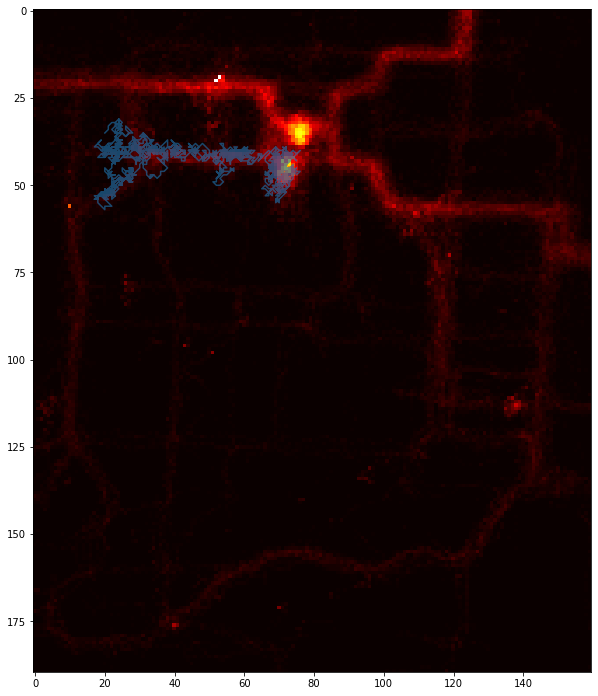

In [98]:
plt.figure(figsize=(10, 15))
plt.imshow(heat_map.T, cmap='hot', interpolation='nearest')
plt.plot(traj[:,0] - pad_size, traj[:,1] - pad_size, alpha=0.6)
plt.show()

In [125]:
seed = 1337
np.random.seed(seed)

start_pos = [100, 175] # position in meters
start_ind = [math.floor(pos/grain) + pad_size for pos in start_pos]

num_steps = 2000
actions = np.array([[-1, -1],
                    [ 0, -1],
                    [ 1, -1],
                    [-1,  0],
                    [ 0,  0],
                    [ 1,  0],
                    [-1,  1],
                    [ 0,  1],
                    [ 1,  1]])
x_inds = actions[:, 0]
y_inds = actions[:, 1]
num_actions = actions.shape[0]
choices = [i for i in range(num_actions)]

## A random walk weighted by values in the heat map and some concept of momentum
num_previous = 40
prev_steps = [num_actions for i in range(num_previous)]
prev_steps += choices

traj = np.zeros((num_steps+1, 2))
traj[0] = start_ind
for step in range(num_steps):
    momentum = np.bincount(prev_steps)
    weights = [momentum[i] * heat_map[int(traj[step, 0] + x_inds[i]), int(traj[step, 1] + y_inds[i])] for i in range(num_actions)]
    weights_sum = sum(weights)
    probs = [weight / weights_sum for weight in weights]
    choice = np.random.choice(choices, p=probs)
    traj[step+1] = traj[step] + actions[choice]
    prev_steps[step % num_previous] = choice

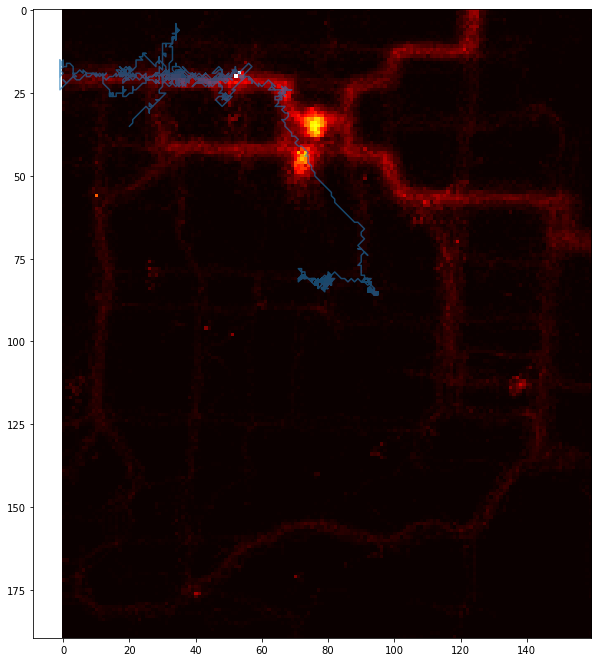

In [126]:
plt.figure(figsize=(10, 15))
plt.imshow(heat_map.T, cmap='hot', interpolation='nearest')
plt.plot(traj[:,0] - pad_size, traj[:,1] - pad_size, alpha=0.6)
plt.show()

In [158]:
seed = 1337
np.random.seed(seed)

start_pos = [100, 175] # position in meters
target_pos = [400, 800] # position in meters
start_ind = [math.floor(pos/grain) + pad_size for pos in start_pos]
target_ind = [math.floor(pos/grain) + pad_size for pos in target_pos]

num_steps = 2000
actions = np.array([[-1, -1],
                    [ 0, -1],
                    [ 1, -1],
                    [-1,  0],
                    [ 0,  0],
                    [ 1,  0],
                    [-1,  1],
                    [ 0,  1],
                    [ 1,  1]])
x_inds = actions[:, 0]
y_inds = actions[:, 1]
num_actions = actions.shape[0]
choices = [i for i in range(num_actions)]

## A random walk weighted by values in the heat map and close-ness to target
traj = np.zeros((num_steps+1, 2))
traj[0] = start_ind
for step in range(num_steps):
    distances = [np.linalg.norm(traj[step] + actions[i] - target_ind) for i in range(num_actions)]
    max_distance = max(distances) + 3
    distances = [max_distance - distance for distance in distances]
    weights = [distances[i] * heat_map[int(traj[step, 0] + x_inds[i]), int(traj[step, 1] + y_inds[i])] for i in range(num_actions)]
    weights_sum = sum(weights)
    probs = [weight / weights_sum for weight in weights]
    choice = np.random.choice(choices, p=probs)
    traj[step+1] = traj[step] + actions[choice]

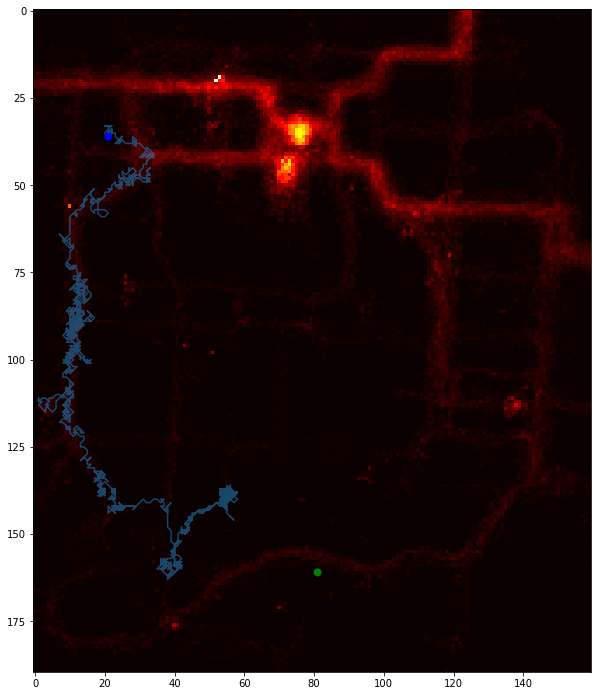

In [159]:
plt.figure(figsize=(10, 15))
plt.imshow(heat_map.T, cmap='hot', interpolation='nearest')
plt.plot(traj[:,0] - pad_size, traj[:,1] - pad_size, alpha=0.6)
plt.gca().add_artist(plt.Circle(start_ind, 1, fill=True, color='blue'))
plt.gca().add_artist(plt.Circle(target_ind, 1, fill=True, color='green'))
plt.show()

In [180]:
seed = 1337
np.random.seed(seed)

start_pos = [100, 175] # position in meters
target_pos = [400, 800] # position in meters
start_ind = [math.floor(pos/grain) + pad_size for pos in start_pos]
target_ind = [math.floor(pos/grain) + pad_size for pos in target_pos]

num_steps = 2000
actions = np.array([[-1, -1],
                    [ 0, -1],
                    [ 1, -1],
                    [-1,  0],
                    [ 0,  0],
                    [ 1,  0],
                    [-1,  1],
                    [ 0,  1],
                    [ 1,  1]])
x_inds = actions[:, 0]
y_inds = actions[:, 1]
num_actions = actions.shape[0]
choices = [i for i in range(num_actions)]

## A random walk weighted by values in the heat map, close-ness to target, and momentum
num_previous = 4
prev_steps = [num_actions for i in range(num_previous)]
prev_steps += choices

traj = np.zeros((num_steps+1, 2))
traj[0] = start_ind
for step in range(num_steps):
    momentum = np.bincount(prev_steps)
    
    distances = [np.linalg.norm(traj[step] + actions[i] - target_ind) for i in range(num_actions)]
    max_distance = max(distances) + 4
    distances = [max_distance - distance for distance in distances]

    weights = [momentum[i] * distances[i] * heat_map[int(traj[step, 0] + x_inds[i]), int(traj[step, 1] + y_inds[i])] for i in range(num_actions)]
    weights_sum = sum(weights)
    probs = [weight / weights_sum for weight in weights]
    choice = np.random.choice(choices, p=probs)
    traj[step+1] = traj[step] + actions[choice]
    
    prev_steps[step % num_previous] = choice

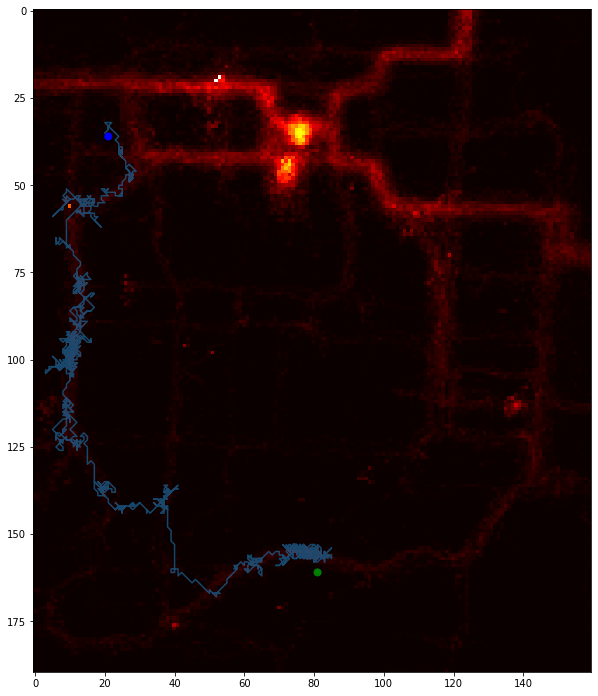

In [181]:
plt.figure(figsize=(10, 15))
plt.imshow(heat_map.T, cmap='hot', interpolation='nearest')
plt.plot(traj[:,0] - pad_size, traj[:,1] - pad_size, alpha=0.6)
plt.gca().add_artist(plt.Circle(start_ind, 1, fill=True, color='blue'))
plt.gca().add_artist(plt.Circle(target_ind, 1, fill=True, color='green'))
plt.show()

Alright, ok, that doesn't look too terrible? Like, it's pretty bad but not like the worst possible?

## Smooth out the resulting trajectory

So it looks reasonably ok, but also pretty terrible, so it would help to smooth out the line a little bit.

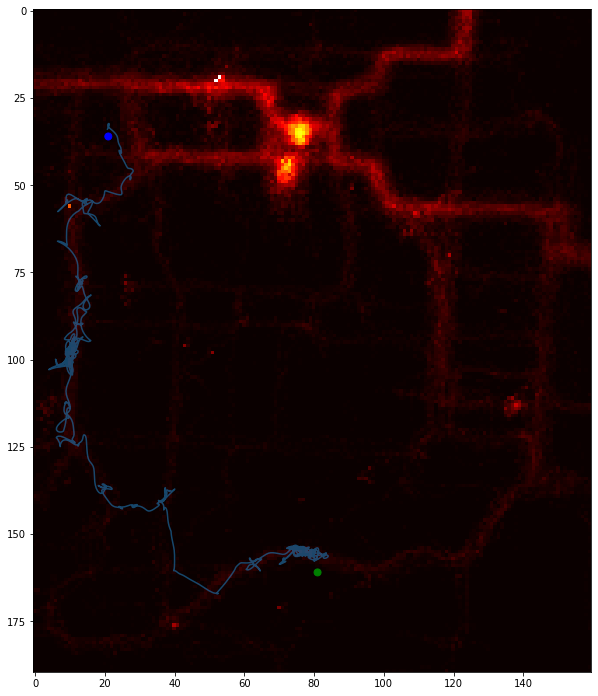

In [184]:
stdev = 2.0
smooth = gaussian_filter1d(traj, stdev, axis=0)
plt.figure(figsize=(10, 15))
plt.imshow(heat_map.T, cmap='hot', interpolation='nearest')
plt.plot(smooth[:,0] - pad_size, smooth[:,1] - pad_size, alpha=0.6)
plt.gca().add_artist(plt.Circle(start_ind, 1, fill=True, color='blue'))
plt.gca().add_artist(plt.Circle(target_ind, 1, fill=True, color='green'))
plt.show()

## Calculating route with time

Assume each step taken is about `grain` size, so if a person goes at some `speed`, each step takes `grain/speed` time. We can then interpolate to have the desired time grainularity.

In [186]:
speed = 1.8 # m/s, approx 4mph walking speed
time_step = grain/speed

In [189]:
time = [i*time_step for i in range(smooth.shape[0])]
func = interp1d(time, smooth, axis=0)

In [190]:
new_time_step = 0.5 # take samples every 0.5 seconds
num_new_times = int(time[-1] / 0.5)
new_time = np.linspace(time[0], time[-1], num=num_new_times, endpoint=True)
interped = func(new_time)

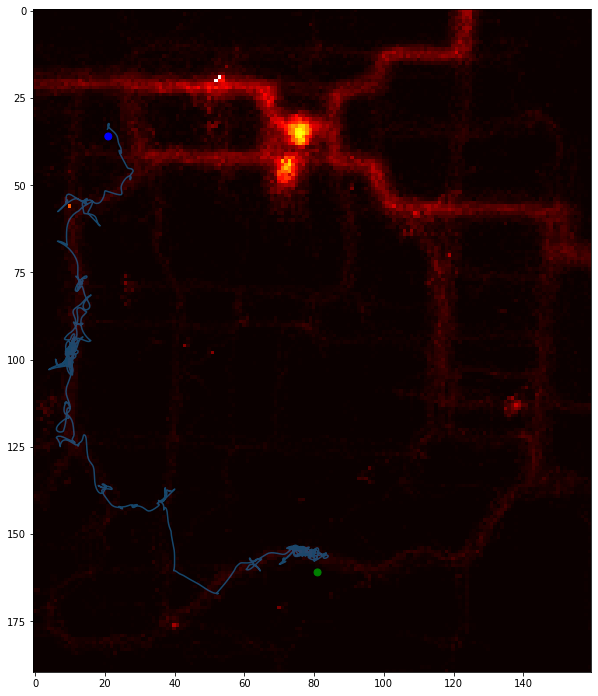

In [191]:
plt.figure(figsize=(10, 15))
plt.imshow(heat_map.T, cmap='hot', interpolation='nearest')
plt.plot(interped[:,0] - pad_size, interped[:,1] - pad_size, alpha=0.6)
plt.gca().add_artist(plt.Circle(start_ind, 1, fill=True, color='blue'))
plt.gca().add_artist(plt.Circle(target_ind, 1, fill=True, color='green'))
plt.show()

## Collect simulation data

Aight, now we can generate a bunch of random mules and sensors and run them around each other. To start off, we will simulate 100 mules and 1000 sensors for one hour. Each mule has its own speed of 1-15 m/s and each sensor has a range of 10-20 m. We ignore WiFi hotspots for now and assume that the mule is able to upload data from anywhere using cellular data.

We want to collect interaction data, as well as some information about the expected traffic flow. Thus, we will collect the following information:

`prob_data/interactions.csv`

|    sensor_id     |     mule_id     | interaction_time | interaction_duration |
|   :---------:    |    :-------:    |:----------------:|:--------------------:|
| i = 1, ..., 1000 | j = 1, ..., 100 |     seconds      |       seconds        |

where `interaction_time` is the time when the mule walks within range of the sensor and `interaction_duration` is the amount of time the mule stays within the sensor range before leaving the range.

We will also collect some metadata on the sensors and mules, which could potentially be helpful?

`prob_data/sensor_metadata.csv`

|    sensor_id     |        x        |       y        |     radius     | traffic |
|   :---------:    |       :-:       |      :-:       |    :------:    |:-------:|
| i = 1, ..., 1000 | x = \[0, 800\]  | y = \[0, 950\] | r = \[10, 20\] |  float  |

where `traffic` is the value of the heatmap in the position that the sensor is at.

`prob_data/mule_metadata.csv`

|     mule_id     |     speed     | displacement |
|    :-------:    |    :-----:    |:------------:|
| j = 1, ..., 100 | s = \[1, 15\] |    meters    |

where `displacement` is the Euclidean distance between the mule's starting and ending positions. It's some measure of how far the mule traveled without needing to record the entire trajectory for each mule.

### Future note:

In case we want to change various parameters in the future, I have marked parameter lines with `#!!` comments so that they are easier to find later.

In [1]:
# import libraries 
import math
import pickle
import numpy as np
from matplotlib import pyplot as plt
from scipy.ndimage import gaussian_filter1d
from scipy.interpolate import interp1d

In [2]:
# generate our heat map and pad it 
file_path = "../galaxy/simulation/smol_attacks/smol_truth/smol_dict.pkl" #!!
with open(file_path, 'rb') as f:
    smol_dict = pickle.load(f)

grain = 5.0 #!!
full_size = [800, 950] #!!
heat_size = [math.ceil(size/grain) for size in full_size]

x_edges = [i*grain for i in range(heat_size[0] + 1)]
y_edges = [j*grain for j in range(heat_size[1] + 1)]
heat_map = np.zeros(heat_size)

for index in smol_dict:
    H, x_edges, y_edges = np.histogram2d(smol_dict[index]['x'], smol_dict[index]['y'], bins=(x_edges, y_edges))
    heat_map += H

pad_size = 1 #!!
padded_map = np.pad(heat_map + 0.1, pad_size) #!!

# remove `smol_dict` from memory to save some space
smol_dict.clear()

In [3]:
# set random seed and generate sensor and mule properties
seed = 1337
np.random.seed(seed)

num_sensors = 1000 #!!
sensors_x = np.random.uniform(0, full_size[0], size=(num_sensors))
sensors_y = np.random.uniform(0, full_size[1], size=(num_sensors))
sensors_r = np.random.uniform(10, 20, size=(num_sensors)) #!!
sensors_traffic = [heat_map[math.floor(x/grain), math.floor(y/grain)] for x, y in zip(sensors_x, sensors_y)]

num_mules = 100 #!!
mules_speed = np.random.uniform(1, 15, size=(num_mules))
mules_start_x = np.random.uniform(0, full_size[0], size=(num_mules))
mules_start_y = np.random.uniform(0, full_size[1], size=(num_mules))
mules_target_x = np.random.uniform(0, full_size[0], size=(num_mules))
mules_target_y = np.random.uniform(0, full_size[1], size=(num_mules))
mules_displacement = [np.linalg.norm([sx - tx, sy - ty]) for sx, tx, sy, ty in zip(mules_start_x, mules_target_x, mules_start_y, mules_target_y)]

In [4]:
# save sensor and mule metadata
sensor_file = "prob_data/sensor_metadata.csv"
with open(sensor_file, 'w') as f:
    f.write("sensor_id,x,y,radius,traffic\n")
    for i in range(num_sensors):
        f.write('{},{},{},{},{}\n'.format(i, sensors_x[i], sensors_y[i], sensors_r[i], sensors_traffic[i]))

mule_file = "prob_data/mule_metadata.csv"
with open(mule_file, 'w') as f:
    f.write("mule_id,speed,displacement\n")
    for j in range(num_mules):
        f.write('{},{},{}\n'.format(j, mules_speed[j], mules_displacement[j]))

In [ ]:
# generate interaction data for each mule
interaction_file = "prob_data/interactions.csv"
with open(interaction_file, 'w') as f:
    f.write("sensor_id,mule_id,interaction_time,interaction_duration\n")

total_time = 60*60 #!!
time_step = 0.1 #!!
num_steps = math.ceil(total_time/time_step)
time = np.linspace(0, total_time, num=num_steps)

actions = np.array([[-1, -1],
                    [ 0, -1],
                    [ 1, -1],
                    [-1,  0],
                    [ 0,  0],
                    [ 1,  0],
                    [-1,  1],
                    [ 0,  1],
                    [ 1,  1]])
x_inds = actions[:, 0]
y_inds = actions[:, 1]
num_actions = actions.shape[0]
choices = [i for i in range(num_actions)]

for j in range(num_mules):
    # generate trajectory for each mule
    start_ind = [math.floor(mules_start_x[j]/grain) + pad_size, math.floor(mules_start_y[j]/grain) + pad_size]
    target_ind = [math.floor(mules_target_x[j]/grain) + pad_size, math.floor(mules_target_y[j]/grain) + pad_size]
    speed = mules_speed[j]
    
    num_steps = math.ceil(total_time * speed / grain)

    ## A random walk weighted by values in the heat map, close-ness to target, and momentum
    num_previous = 4 #!!
    prev_steps = [num_actions for _ in range(num_previous)]
    prev_steps += choices

    sim_traj = np.zeros((num_steps+1, 2))
    sim_traj[0] = start_ind
    for step in range(num_steps):
        momentum = np.bincount(prev_steps)

        distances = [np.linalg.norm(sim_traj[step] + actions[act] - target_ind) for act in range(num_actions)]
        max_distance = max(distances) + 4 #!!
        distances = [max_distance - distance for distance in distances]

        weights = [momentum[act] * distances[act] * padded_map[int(sim_traj[step, 0] + x_inds[act]), int(sim_traj[step, 1] + y_inds[act])] for act in range(num_actions)]
        weights_sum = sum(weights)
        probs = [weight / weights_sum for weight in weights]
        choice = np.random.choice(choices, p=probs)
        sim_traj[step+1] = sim_traj[step] + actions[choice]

        prev_steps[step % num_previous] = choice
    
    # smooth trajectory and scale to normal life size
    stdev = 2.0
    traj = gaussian_filter1d(sim_traj - pad_size, stdev, axis=0) * grain
    
    # interpolate simulation steps into `time_step` chunks
    sim_step = grain/speed
    sim_time = [s*sim_step for s in range(traj.shape[0])]
    func = interp1d(sim_time, traj, axis=0)
    traj = func(time)
    
    # iterate through each time step, check collisions with each sensor, and record our results
    with open(interaction_file, 'a') as f:
        current_sensors = dict()
        for t in range(num_steps):
            collisions = []
            for i in range(num_sensors):
                if np.linalg.norm([traj[t,0]-sensors_x[i], traj[t,1]-sensors_y[i]]) < sensors_r[i]:
                    collisions.append(i)

            # if we left the range of a sensor, append the results to our file
            lost_sensors = []
            for sensor in current_sensors:
                if sensor not in collisions:
                    lost_sensors.append(sensor)
                    f.write('{},{},{},{}\n'.format(sensor, j, current_sensors[sensor] * time_step, (t - current_sensors[sensor]) * time_step))
            for sensor in lost_sensors:
                del current_sensors[sensor]

            # if we entered the range of a sensor, add it to our current sensors
            for sensor in collisions:
                if sensor not in current_sensors:
                    current_sensors[sensor] = t

        # empty out our dictionary at the end of the simulation
        for sensor in current_sensors:
            f.write('{},{},{},{}\n'.format(sensor, j, current_sensors[sensor] * time_step, total_time - (current_sensors[sensor] * time_step)))
        
    # quick print statement for sanity
    print('finished processing mule {}'.format(j))
            

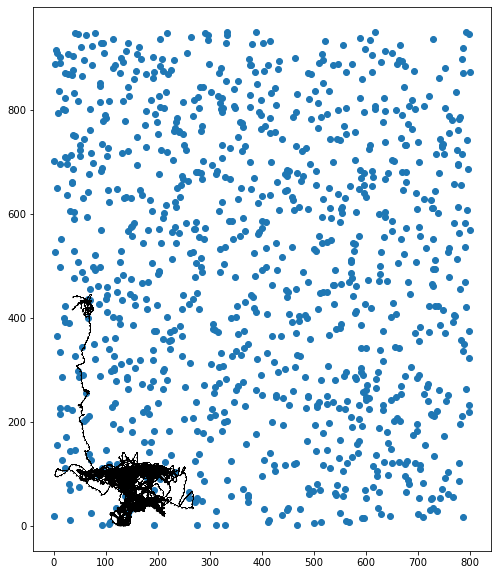

In [6]:
plt.figure(figsize=(15, 10))
plt.gca().set_aspect('equal')
plt.scatter(sensors_x, sensors_y)
plt.plot(traj[:,0], traj[:,1], 'k,:')
plt.show()